In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2021-05-18 16:15:16.982918
Simons Foundation, Rusty HPC, worker3048


In [2]:
%cd /mnt/home/zzhang/ceph/jemm
%load_ext rpy2.ipython

/mnt/ceph/users/zzhang/jemm


In [3]:
# import everything we will need from jemm
from jemm.junction import JunctionCountTable
from jemm.transcript import TranscriptMeasureTable
from jemm.model import Jemm, JemmLinearRegression
from jemm.plots import facet_boxplot, beta_barplot
from jemm.covariate import Contrasts, Covariate

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, roc_auc_score

import pickle
import numpy as np
import pandas as pd
import os
import random

from jemm.meta_loader import MetaLoader
from jemm.covariate import Contrasts, Covariate

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'ieee'])
import scipy

DATA_VER = 'data-V7'
PCS_TO_INCL = '0,6'
USE_RE = True

CLFDIR = '%s/das_classifier' % DATA_VER
os.makedirs(CLFDIR, exist_ok=True)

%run ./notebook/navy_utils.py $DATA_VER $PCS_TO_INCL $USE_RE

navy_utils.py data-V7 ['PC0', 'PC6'] True


In [4]:
data_files = {
    'SE': {
        'jct': './%s/compiled/jct_SE.reduced.pkl' % DATA_VER,
        'txr': './%s/compiled/txr_SE.reduced.pkl'% DATA_VER
    }, 
    'A5SS': {
        'jct': './%s/compiled/jct_A5SS.pkl'% DATA_VER,
        'txr': './%s/compiled/txr_A5SS.pkl'% DATA_VER
    }, 
    'A3SS': {
        'jct': './%s/compiled/jct_A3SS.pkl'% DATA_VER,
        'txr': './%s/compiled/txr_A3SS.pkl'% DATA_VER
    }, 
    'RI': {
        'jct': './%s/compiled/jct_RI.pkl'% DATA_VER,
        'txr': './%s/compiled/txr_RI.pkl'% DATA_VER
    }
}

reg_tables = {
    'SE': './%s/joint_SE/joint.SE.reg_table.tsv'% DATA_VER,
    'A5SS': './%s/joint_A5SS/joint.A5SS.reg_table.tsv'% DATA_VER,
    'A3SS': './%s/joint_A3SS/joint.A3SS.reg_table.tsv'% DATA_VER,
    'RI': './%s/joint_RI/joint.RI.reg_table.tsv'% DATA_VER
}


contrast_cols = ['final@Pre', 'final@First', 'final@Mid', 'final@Post', 
                 'final@False Negative','final@Immune', 'final@Reinfection',
                 'final@Asymptomatic', 
                 'final@Exposed', 
                 'final@Mild',
                 'final@Moderate']

metaloader = MetaLoader(covs, data_files, reg_tables,
                        jem_type='lmm' if USE_RE else 'lm',
                        jem_kwargs={'diff_intercept_by_measure':True,
                            'group_varname': 'pid'})

loading SE..
loaded n=(32186, 1176) jct, n=(35113, 1176) txr


/mnt/ceph/users/zzhang/jemm/jemm/model.py:101: UserWarning: Input covariate matrix has condition number = 39465.809801933814 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


loading A5SS..
loaded n=(5126, 1444) jct, n=(17687, 1444) txr
loading A3SS..
loaded n=(7557, 1444) jct, n=(19353, 1444) txr
loading RI..
loaded n=(5341, 1444) jct, n=(7345, 1444) txr


In [5]:
duke_folder = 'duke_whole_blood'
duke_data_files = {
    'SE': {
        'jct': './data/%s/jct_SE.pkl' % duke_folder,
        'txr': './data/%s/txr_SE.pkl' % duke_folder
    }, 
    'A5SS': {
        'jct': './data/%s/jct_A5SS.pkl' % duke_folder,
        'txr': './data/%s/txr_A5SS.pkl' % duke_folder
    }, 
    'A3SS': {
        'jct': './data/%s/jct_A3SS.pkl' % duke_folder,
        'txr': './data/%s/txr_A3SS.pkl' % duke_folder
    }, 
    'RI': {
        'jct': './data/%s/jct_RI.pkl' % duke_folder,
        'txr': './data/%s/txr_RI.pkl' % duke_folder
    }
}

duke_contrasts = Contrasts(name="Pathogen", levels=[
    'healthy', 
    'COVID-19'
])
duke_covs_wb = Covariate(fp="./data/%s/meta_full.tsv" %duke_folder, sep="\t", 
                 index_col=0,
                 contrasts=duke_contrasts,
                 main_effects=['Pathogen', 'gender', 'days_since_onset'],
                 verbose=True
             )
duke_wb_metaloader = MetaLoader(duke_covs_wb, duke_data_files,
                       jem_kwargs={'diff_intercept_by_measure':True})

loading SE..
loaded n=(41922, 66) jct, n=(47847, 66) txr
loading A5SS..
loaded n=(3822, 66) jct, n=(17687, 66) txr
loading A3SS..
loaded n=(5711, 66) jct, n=(19353, 66) txr
loading RI..
loaded n=(4593, 66) jct, n=(7345, 66) txr


In [6]:
def get_psi_df(tot_eids, metaloader, use_jct=True, use_txr=True, dropnan=True, min_eid_cov=0):
    psi_df_list = []
    for as_type in ['SE', 'A5SS', 'A3SS', 'RI']:
        if not as_type in tot_eids:
            continue
        eids = [e for e in tot_eids[as_type]]
        if use_jct:
            jct = metaloader.data[as_type].junction_measure.reindex(eids).applymap(lambda x: x if type(x) is float else x.psi)
            jct.rename(index=lambda x: 'jct:%s:'%as_type + x, inplace=True)
            psi_df_list.append(jct.transpose())
        if use_txr:
            txr = metaloader.data[as_type].transcript_measure.reindex(eids).applymap(lambda x: x if type(x) is float else x.psi)
            txr.rename(index=lambda x: 'txr:%s:'%as_type + x, inplace=True)
            psi_df_list.append(txr.transpose())
    psi_df = pd.concat(psi_df_list, axis=1)
    if dropnan is True:
        psi_df = psi_df.dropna(axis=1)
    if min_eid_cov > 0:
        eid_cov = psi_df.apply(lambda x: np.std(x)/(np.mean(x)+0.01), axis=0)
        psi_df = psi_df.loc[:, eid_cov>min_eid_cov]
    
    return psi_df

In [7]:
## DATA PREPARATION FOR CONSISTENCY WITH `09-Navy_predictive-model.ipynb`


## ----- GET PRE ----- ##
# get total pre samples with RNA-seq (in sample index)
total_pre = covs.meta.loc[covs.meta.final=='Pre']
total_pre=set(list([x for x in metaloader.data['SE'].sample_index if x in total_pre.index]))
pre_subject_ids = list(set([x.split('-')[0] for x in total_pre]))
pre_subject_samps = list(set([(y, covs.meta.loc[y, 'final'], covs.meta.loc[y, 'Sex']) for x in pre_subject_ids
                     for y in metaloader.data['SE'].sample_index if y.split('-')[0] == x]))

# up to here is a list of (sid, final), where the individual is Pre at one tp
pre_df = pd.DataFrame(pre_subject_samps, columns=['ID', 'final', 'Sex'])

# adding a preceding P is necessary as to not confuse seaborn..
pre_df['individual'] = ["P"+x.split('-')[0] for x in pre_df['ID']]
pre_df['tp'] = [int(x.split('-')[1].lstrip('T')) for x in pre_df['ID']]
pre_df.index = pre_df['ID']
print(pre_df.shape)

# this is a df of controls that with Pre
print(pre_df.head())


## ----- GET INFECTED DF FOR TRAINING ----- ##
# get total first/first-mid/mid samples with RNA-seq (in sample index)
total_infect = covs.meta.loc[covs.meta.final.isin(['Control','Pre', 'First', 'Mid'])]

# get the ones with RNA-seq
total_infect = [x for x in metaloader.data['SE'].sample_index if x in total_infect.index]

# strip the subject ids
inft_subject_ids = list(set([x.split('-')[0] for x in total_infect]))

# dummy join
inft_subject_samps = [(y, covs.meta.loc[y, 'final'], covs.meta.loc[y, 'Sex']) for x in inft_subject_ids
                     for y in metaloader.data['SE'].sample_index \
                     if y.split('-')[0] == x and y.split('-')[0]]

# up to here is a list of (sid, final), where the individual is Pre at one tp
inft_df = pd.DataFrame(inft_subject_samps, columns=['ID', 'final', 'Sex'])
inft_df.drop_duplicates(inplace=True)

# adding a preceding P is necessary as to not confuse seaborn..
inft_df['individual'] = ["P"+x.split('-')[0] for x in inft_df['ID']]
inft_df['tp'] = [int(x.split('-')[1].lstrip('T')) for x in inft_df['ID']]
inft_df.index = inft_df['ID']
inft_df = inft_df.loc[inft_df.final.isin(['Control','First', 'Mid'])]
print(inft_df.shape)
print(inft_df['final'].unique())


## ----- EXCLUDE PRE-CONTROL SAMPLES ----- ##
# Do not include Pre, and Controls related to Pre
infect_train_df = inft_df.loc[~inft_df['ID'].isin(pre_df.loc[pre_df['final'].isin(['Control', 'Pre'])]['ID'])]

(235, 5)
                      ID  final Sex individual  tp
ID                                                
20_0196-T91  20_0196-T91   Post   F   P20_0196  91
20_0162-T35  20_0162-T35  First   F   P20_0162  35
20_0165-T28  20_0165-T28    Pre   F   P20_0165  28
20_0255-T49  20_0255-T49   Post   F   P20_0255  49
20_0217-T28  20_0217-T28    Pre   M   P20_0217  28
(532, 5)
['First' 'Control' 'Mid']


In [8]:
def build_classifier(feature_eids, train_conds, reweight=True):
    stats = {}
    feature_psi_df = get_psi_df(feature_eids, metaloader, use_jct=False, use_txr=True)
    stats['feature_psi.shape'] = feature_psi_df.shape
    train_df = infect_train_df.loc[infect_train_df['final'].isin(train_conds)]

    stats['train_df.shape'] = train_df.shape
    stats['feature_df.columns'] = feature_psi_df.columns
    X_train = feature_psi_df.loc[train_df.ID].to_numpy()
    y_train = np.array([1 if train_df['final'][i]!='Control' else 0 for i in range(train_df.shape[0])])
    prop_y = np.mean(y_train)
    if reweight is True:
        stats['clf.class_weight'] = (1-prop_y)/prop_y 
    else:
        stats['clf.class_weight'] = 1
        
    clf = LogisticRegression(
        class_weight={0:1, 1: (1-prop_y)/prop_y if reweight is True else 1},
        penalty='l2', 
        C=1,
        solver='liblinear', 
        max_iter=1000, 
        random_state=777
    )
    cvx = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    y_pred = cross_val_predict(clf, X_train, y_train, cv=cvx, method='predict_proba', n_jobs=1)
    clf.fit(X_train, y_train)
    pred_train = clf.predict_proba(X_train)[:, 1]
    #train_df['first_clf_pred'] = pred_train
    stats['clf.coef'] = pd.Series(clf.coef_[0], index=feature_psi_df.columns)
    stats['y_train.cv_pred'] = y_pred
    return clf, train_df, feature_psi_df, stats

In [9]:
# Use Duke study with whole-blood samples
duke_metaloader = duke_wb_metaloader
duke_covs = duke_covs_wb

def build_tester(trained_clf, feature_eids, feature_df_columns):
    stats = {}
    duke_psi_df = get_psi_df(feature_eids, duke_metaloader, dropnan=False)
    # re-order the x matrix so it matched the beta
    duke_psi_df = duke_psi_df.loc[:, feature_df_columns]
    duke_psi_df.fillna(duke_psi_df.mean(skipna=True), inplace=True)
    duke_psi_df.fillna(0.5, inplace=True)
    stats['n_features'] = duke_psi_df.shape[1]
    duke_X = duke_psi_df.to_numpy()
    duke_y = np.array(
        # meta_full.tsv
        [1 if duke_covs.meta.loc[i, 'Pathogen']=='COVID-19' else 0 for i in duke_metaloader.data['SE'].junction_measure.columns]
    )
    duke_pred = trained_clf.predict_proba(duke_X)[:,1]
    stats['test_aupr'] = average_precision_score(duke_y, duke_pred)
    stats['test_auc'] = roc_auc_score(duke_y, duke_pred)
    return duke_y, duke_pred, duke_psi_df, stats

In [10]:
## --- REPRODUCE OLD RESULTS ----- ##

config = {
        'feature_eids': {
            as_type:[ e 
                for e in sorted(metaloader.data[as_type].stats_tests)
                if metaloader.data[as_type].stats_tests[e].loc['final@First', 'qvals']<0.001
        ]
        for as_type in metaloader.data},

        #'feature_eids': {
        #    d[0]: d[1].event_id.to_list()
        #    for d in feature_eids.groupby('event_type')
        #},
        'train_conds': ('Control', 'First'),
}

clf, train_df, train_psi_df, train_stat = build_classifier(
    feature_eids=config['feature_eids'], 
    train_conds=config['train_conds'])
duke_y, duke_pred, duke_psi_df, test_stat = build_tester(
    trained_clf=clf,
    feature_eids=config['feature_eids'], 
    feature_df_columns=train_stat['feature_df.columns']
)

print(test_stat)

{'n_features': 363, 'test_aupr': 0.9016883852613478, 'test_auc': 0.83986562150056}


In [11]:
# Order the events by importance

best_train_stats = train_stat
best_coefs_abs_ = best_train_stats['clf.coef'].abs().sort_values(ascending=False)
best_coefs = best_train_stats['clf.coef']
len(best_coefs_abs_)

363

In [12]:
# Heuristic for forward step selection
from tqdm import tqdm

as_types = ['SE', 'A5SS', 'A3SS', 'RI']
old_eids = {x:[] for x in as_types}
old_test_auc = 0

fluidigm_evts = []

for i, as_eid in enumerate(best_coefs_abs_.index):
    eid = ':'.join(as_eid.split(':')[2:])
    this_type = as_eid.split(':')[1]
    genename = metaloader._reg_tables[this_type].loc[eid,  'geneSymbol' ]
    new_config = {
        'feature_eids': {
            as_type: old_eids[as_type] if as_type != this_type else old_eids[as_type] + [eid]
        for as_type in as_types},
        'train_conds': ('Control', 'First'),
    }
    clf, train_df, train_psi_df, train_stat = build_classifier(
        feature_eids=new_config['feature_eids'], 
        train_conds=new_config['train_conds'],
        reweight=False
    )
    duke_y, duke_pred, duke_psi_df, test_stat = build_tester(
        trained_clf=clf,
        feature_eids=new_config['feature_eids'], 
        feature_df_columns=train_stat['feature_df.columns']
    )
    if test_stat['test_auc'] > old_test_auc:
        old_eids[this_type].append(eid)
        old_test_auc = test_stat['test_auc']
        print('%i/%i, Added %s,%s, auc=%.3f' % (i, len(best_coefs_abs_), eid, genename, old_test_auc))
        fluidigm_evts.append({'step': i, 'auc': old_test_auc, 'genename': genename, 'evt': eid, 'as_type': this_type})
    else:
        #print('%i/%i, Skipped %s' %  (i, len(best_coefs_abs_), eid))
        pass

fluidigm_evts = pd.DataFrame(fluidigm_evts)
print('total added = %i' % fluidigm_evts.shape[0])

0/363, Added chr22:+:22888259:22893699:22893818:22895374,IGLL5, auc=0.622
1/363, Added chr6:+:31587199:31587318:31588517:31588909,LST1, auc=0.782
2/363, Added chr16:-:88841971:88842705:88842829:88856757,GALNS, auc=0.852
3/363, Added chr13:-:42917624:42919299:42919332:42926335,EPSTI1, auc=0.882
10/363, Added chr19:-:54276806:54276929:54277549:54277600,LILRB2, auc=0.897
20/363, Added chr20:+:19935199:19935438:19935607:19956614,RIN2, auc=0.910
23/363, Added chr9:+:110138539:110156318:110156497:110168398,PALM2AKAP2, auc=0.912
28/363, Added chr1:+:26473482:26473527:26473702:26474135,HMGN2, auc=0.922
30/363, Added chr22:+:18110868:18121478:18110839:18121478,TUBA8, auc=0.936
32/363, Added chr6:+:31835451:31836423:31836517:31837235,SNHG32, auc=0.938
33/363, Added chr16:+:29804065:29804575:29804065:29804813,KIF22, auc=0.948
34/363, Added chr1:+:43975848:43976089:43975107:43976089,ATP6V0B, auc=0.953
36/363, Added chr11:-:95185492:95189778:95189961:95191403,SESN3, auc=0.954
41/363, Added chr6:+:3

Text(0, 0.5, 'Duke AUC')

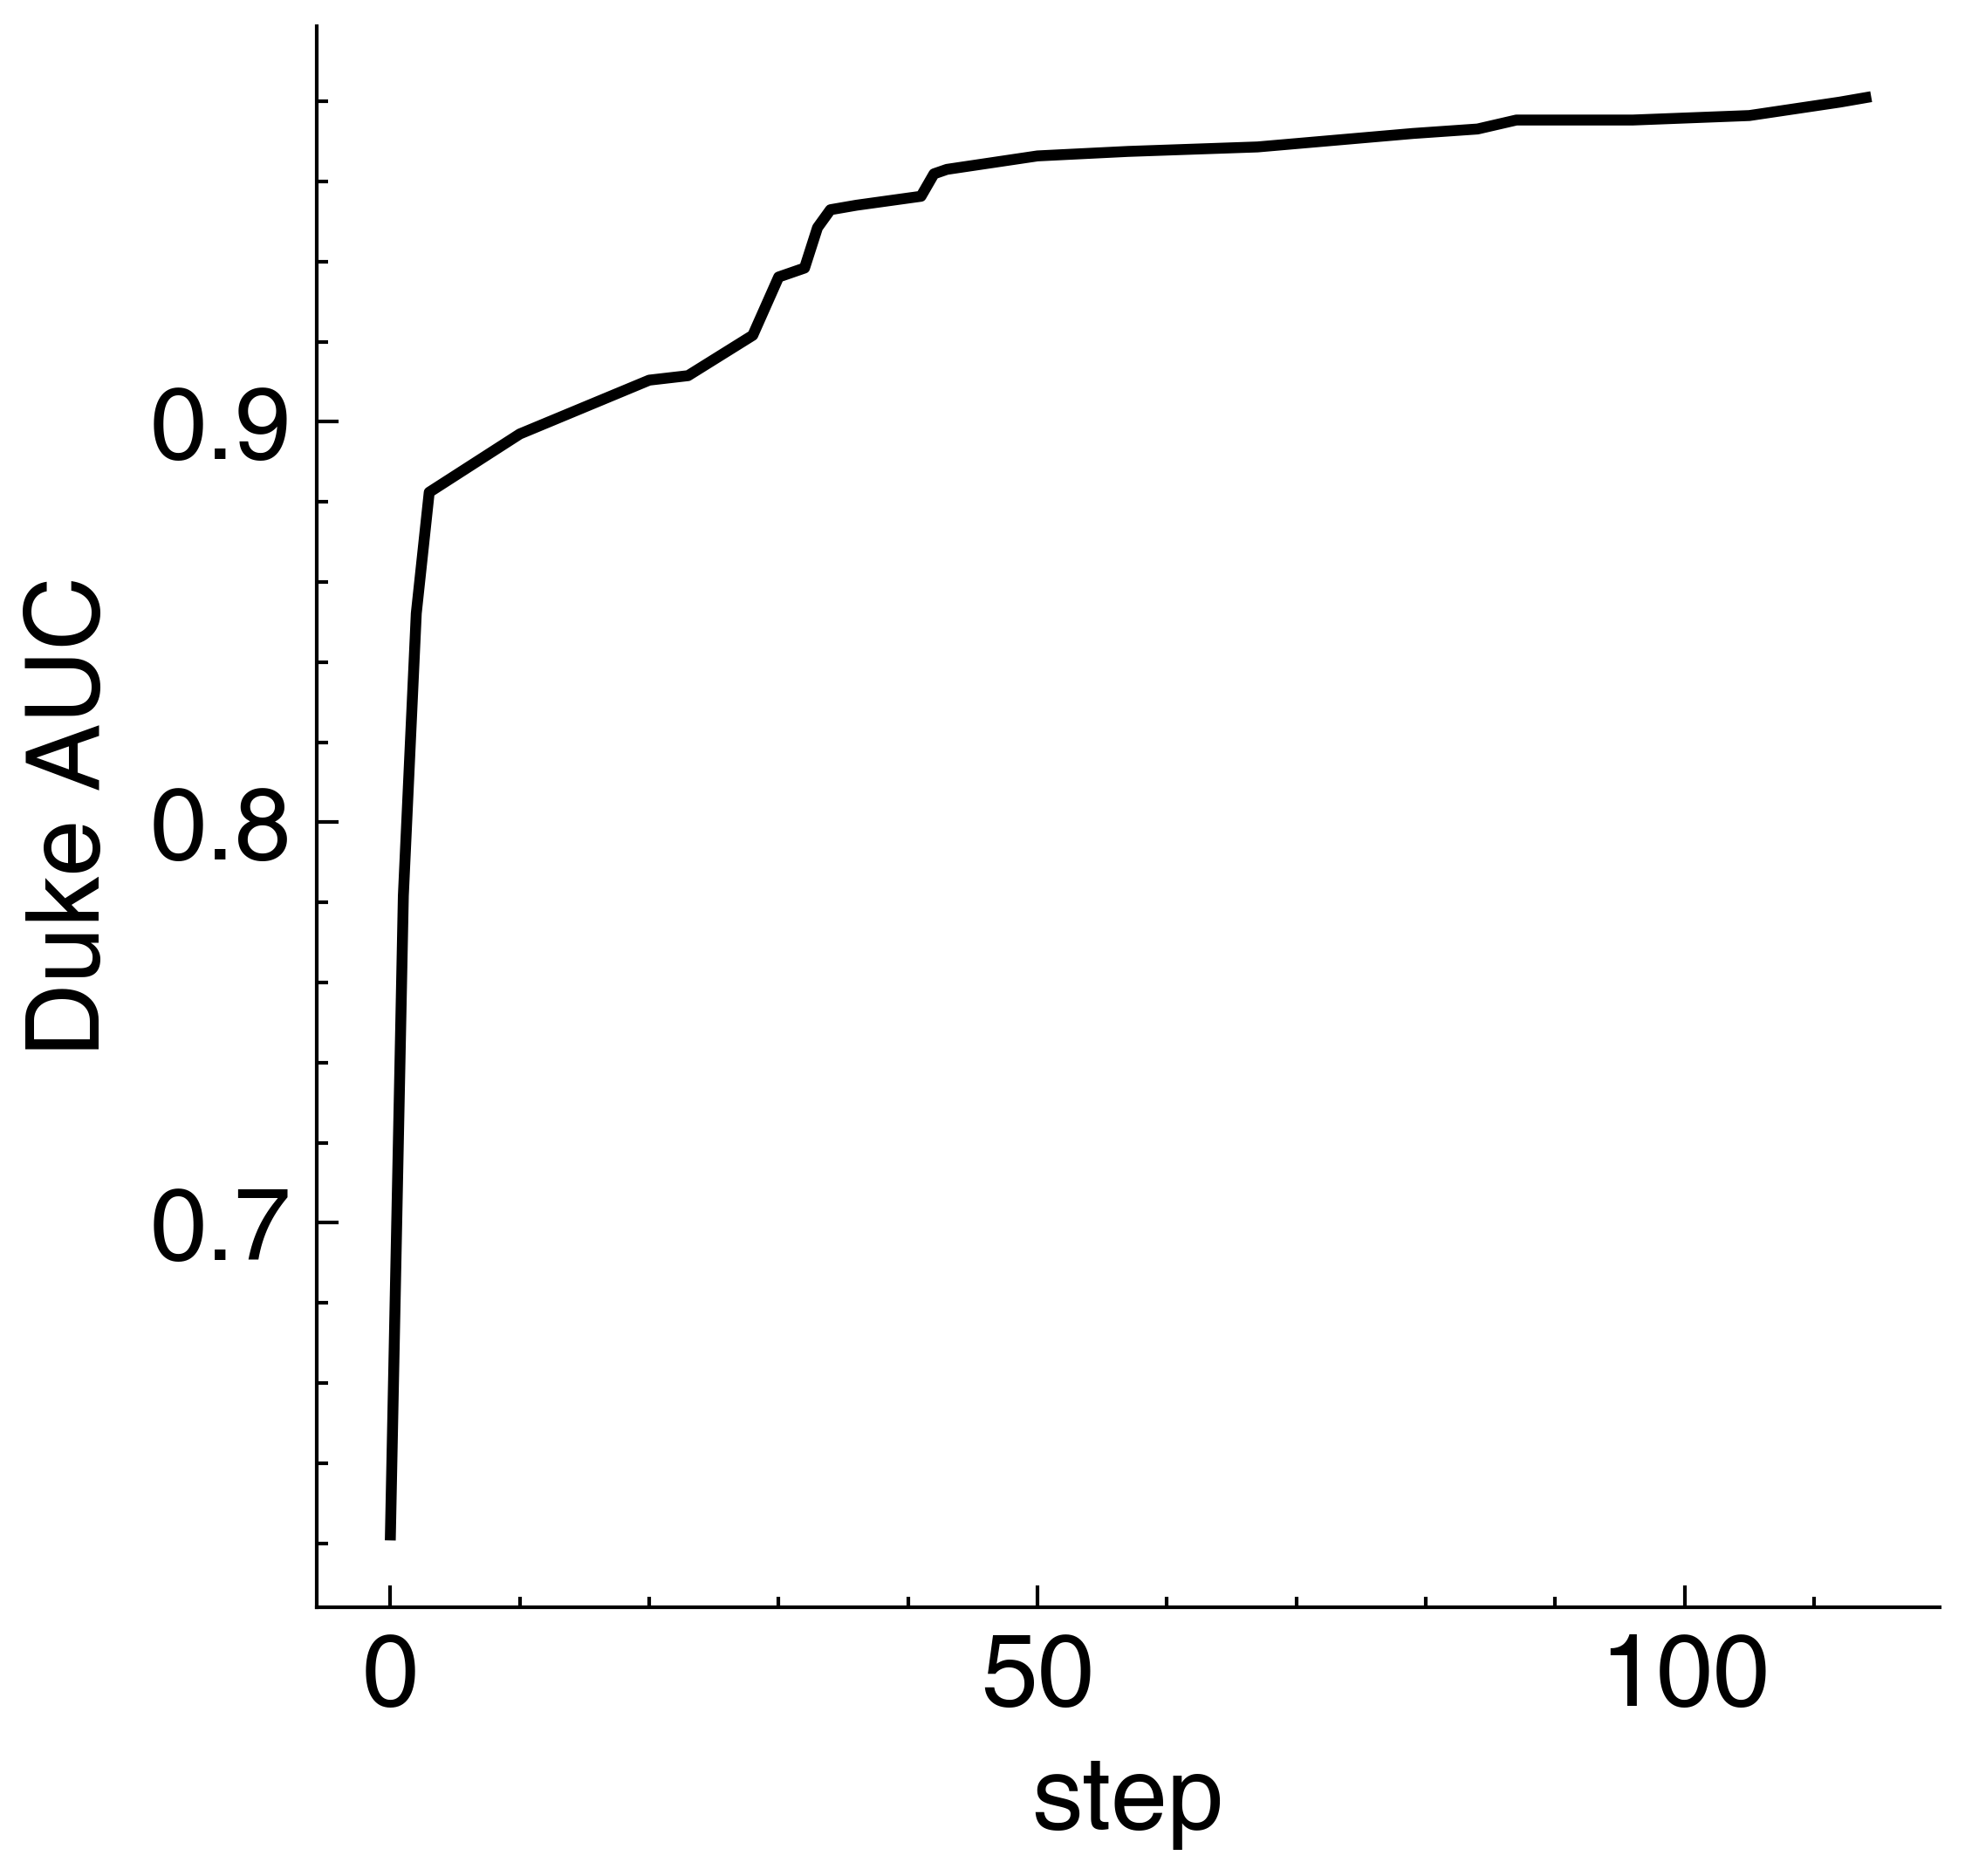

In [13]:
ax = sns.lineplot(x='step', y='auc', data=fluidigm_evts, ls='-')
ax.set_ylabel('Duke AUC')

In [14]:
duke_pred

array([0.84469144, 0.71180965, 0.84930823, 0.66129181, 0.84622584,
       0.82230968, 0.86712626, 0.7536417 , 0.85183372, 0.77025027,
       0.73774454, 0.71121587, 0.77260711, 0.73257804, 0.71159475,
       0.58978747, 0.14442639, 0.56878497, 0.64479935, 0.92721597,
       0.56858344, 0.70295529, 0.91073764, 0.80706796, 0.82821055,
       0.7670163 , 0.7355656 , 0.58484036, 0.76092392, 0.74791226,
       0.91168258, 0.57316235, 0.52767237, 0.71483095, 0.98097552,
       0.85380515, 0.77109255, 0.80304023, 0.58508292, 0.66502864,
       0.84229295, 0.96278487, 0.63273142, 0.89740213, 0.88244277,
       0.9072496 , 0.93174194, 0.29176437, 0.30627167, 0.23937426,
       0.21817807, 0.46757784, 0.39275124, 0.36825618, 0.40574028,
       0.33256637, 0.52140924, 0.43191615, 0.05845509, 0.44363537,
       0.27737503, 0.43730002, 0.20818082, 0.50514607, 0.21144118,
       0.10669745])

In [15]:
def get_isoform_junctions(evt, as_type):
    TYPE_TO_ISOFORM = {
        'SE': {'long': [(0,1), (2,3)], 'short': [(0,3)]},
        'RI': {'long': [(1,), (2,)], 'short': [(1,2)]},
        'A3SS': {'long': [(0,1)], 'short': [(2,3)]},
        'A5SS': {'long': [(0,1)], 'short': [(2,3)]},
    }
    ele = evt.split(':')
    chrom = ele.pop(0)
    strand = ele.pop(0)
    if as_type!='RI':
        long_ = ['-'.join([ele[i] for i in x]) for x in TYPE_TO_ISOFORM[as_type]['long']]
    else:
        long_ = ['-'.join([str(int(ele[i]) + f) for i in x for f in [-20, 20]]) for x in TYPE_TO_ISOFORM[as_type]['long']]
        
    short_ = ['-'.join([ele[i] for i in x]) for x in TYPE_TO_ISOFORM[as_type]['short']]
    long = ';'.join(['%s:%s' % (chrom, x) for x in long_])
    short = ';'.join(['%s:%s' % (chrom, x) for x in short_])
    return {'strand':strand, 'long': long, 'short': short}

In [17]:
# Get the isoform junctions
junctions = [get_isoform_junctions(row['evt'], row['as_type']) for _, row in fluidigm_evts.iterrows()]
fluidigm_evts = fluidigm_evts[['step', 'auc', 'genename', 'evt', 'as_type']]
fluidigm_evts = pd.concat([fluidigm_evts, pd.DataFrame(junctions)], axis=1)

In [18]:
fluidigm_evts

,step,auc,genename,evt,as_type,strand,long,short
0,0,0.622060,IGLL5,chr22:+:22888259:22893699:22893818:22895374,SE,+,chr22:22888259-22893699;chr22:22893818-22895374,chr22:22888259-22895374
1,1,0.781635,LST1,chr6:+:31587199:31587318:31588517:31588909,RI,+,chr6:31587298-31587338;chr6:31588497-31588537,chr6:31587318-31588517
2,2,0.852184,GALNS,chr16:-:88841971:88842705:88842829:88856757,SE,-,chr16:88841971-88842705;chr16:88842829-88856757,chr16:88841971-88856757
3,3,0.882419,EPSTI1,chr13:-:42917624:42919299:42919332:42926335,SE,-,chr13:42917624-42919299;chr13:42919332-42926335,chr13:42917624-42926335
4,10,0.896976,LILRB2,chr19:-:54276806:54276929:54277549:54277600,RI,-,chr19:54276909-54276949;chr19:54277529-54277569,chr19:54276929-54277549
5,20,0.910414,RIN2,chr20:+:19935199:19935438:19935607:19956614,SE,+,chr20:19935199-19935438;chr20:19935607-19956614,chr20:19935199-19956614
6,23,0.911534,PALM2AKAP2,chr9:+:110138539:110156318:110156497:110168398,SE,+,chr9:110138539-110156318;chr9:110156497-110168398,chr9:110138539-110168398
7,28,0.921613,HMGN2,chr1:+:26473482:26473527:26473702:26474135,RI,+,chr1:26473507-26473547;chr1:26473682-26473722,chr1:26473527-26473702
8,30,0.936170,TUBA8,chr22:+:18110868:18121478:18110839:18121478,A5SS,+,chr22:18110868-18121478,chr22:18110839-18121478
9,32,0.938410,SNHG32,chr6:+:31835451:31836423:31836517:31837235,SE,+,chr6:31835451-31836423;chr6:31836517-31837235,chr6:31835451-31837235


In [19]:
fluidigm_evts.to_csv('%s/fluidigm/fluidigm_evts.patch1.fixRI.tsv'%DATA_VER, sep="\t", index=False)

In [20]:
print("FINISH:", datetime.now())

FINISH: 2021-05-18 16:55:45.337602
